# Example 4

# Calculating $D_{min}$ Scale Factor Using Ground Motion Parameters

This example will show how to calculate a scale factor for Darendeli's $D_{min}$ to match a surface motion's ground motion parameters based on a specified base input motion and soil profile.

## Relevant Ground Motion Parameters
<p style="margin-left: 20px;">
• <b>Peak Ground Acceleration (PGA)</b><br>
• <b>Peak Ground Velocity (PGV)</b><br>
• <b>Arias Intensity</b> (Ia)
</p>

## Procedure

1. <b>Extract recorded surface motion parameters</b>  
   <span style="margin-left: 30px;">- Calculate PGA, PGV, and Ia from surface motion data.</span>

2. <b>Get empirical $D_{min}$</b>  
   <span style="margin-left: 30px;">- Use Darendeli's model to empirically estimate Dmin.</span>

3. <b>Run site response analysis</b>  
   <span style="margin-left: 30px;">- Perform linear elastic analysis with the base motion.</span>  
   <span style="margin-left: 40px;"><b>3.1</b> Record calculated theoretical surface PGA, PGV, Ia</span>  
   <span style="margin-left: 40px;"><b>3.2</b> Compare results with the recorded surface motion:</span>  
   <span style="margin-left: 50px;">→ If theoretical ≠ empirical:</span>  
   <span style="margin-left: 60px;">• Adjust Dmin scaling factor</span>  
   <span style="margin-left: 60px;">• Repeat until parameters match (i.e. tolerance = ??)</span> 


### Step 0: Import Ground Motion Data

In this case, two MSEED files for a small-strain ground motion are to be analyzed. This example includes the processed base and surface motions from an event recorded at the Kik-Net site *TCGH16*.  
  
  
These are the same two motions that were examined in Example 3 (calculating a $\kappa$-based Scale Factor).

In [1]:
from datools import site_response_small, scale_factors, signal_processing
import matplotlib.pyplot as plt

base_motion = signal_processing.genstream("data/Example_3/base","MSEED")
surface_motion = signal_processing.genstream("data/Example_3/surface","MSEED")

Total traces combined: 1
Total traces combined: 1


### Step 1: Calculate the PGA, PGV, and Ia of the Recorded Surface Motion

In [2]:
emp_attr=scale_factors.consolidate_parameters(surface_motion)
#Note, this is an intermediary step, but PGA is in g, PGV in cm/s, and Ia in (m/s)

/Users/griffinberse/Documents/datools/src/datools/scale_factors.py:285: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ids = pd.concat([ids, new_row], ignore_index=True)
/Users/griffinberse/Documents/datools/src/datools/scale_factors.py:295: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ids = pd.concat([ids, new_row], ignore_index=True)
/Users/griffinberse/Documents/datools/src/datools/scale_factors.py:308: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is dep

### Step 2: Use the Darendeli Model to Establish initial $D_{min}$

In [3]:
#### Generating the Site Profile for TCGH16
site_data = site_response_small.parse_site_data('data/Example_2/site_data.txt')
profile_df=site_data['TCGH16'].copy()

#### Calculate Darendeli Dmin
profile_df['damp_min'] = profile_df.apply(scale_factors.calc_damp_min, axis=1)

print(f"Data for TCGH16:")
print(profile_df.head())

Data for TCGH16:
   Layer     Vs  Mean_Stress  OCR    PI  Unit_Weight  Thickness  damp_min
0      1   80.0        26.67  1.0  10.0         20.0        4.0  0.014141
1      2  160.0        66.92  1.0  10.0         20.0        4.0  0.010821
2      3  280.0       114.47  1.0  10.0         20.0       10.0  0.009258
3      4  400.0       250.34  1.0  10.0         20.0       30.0  0.007374
4      5  450.0       447.35  1.0  10.0         20.0       28.0  0.006230


### Step 3: Run LE Site Response Analysis

Outlined in the introduction to this example, to find the ground motion parameter $D_{min}$ value can be 

In [4]:
motions=site_response_small.convert_to_motion(base_motion,'EW1')

In [8]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
sf_list = np.arange(1, 20, 1)
theo_pga_df = scale_factors.pga_gmp_sf(motions,profile_df,emp_attr,sf_list)
sf_list = np.arange(1, 20, 1)
theo_pgv_df = scale_factors.pgv_gmp_sf(motions,profile_df,emp_attr,sf_list)
theo_ia_df = scale_factors.ia_gmp_sf(motions,profile_df,emp_attr,sf_list)




print(f"The PGA Scale Factor is: {theo_pga_df['pga_SF'][0]}")
print(f"The PGV Scale Factor is: {theo_pgv_df['pgv_SF'][0]}")
print(f"The Ia Scale Factor is: {theo_ia_df['ia_SF'][0]}")


The PGA Scale Factor is: 0.30999999999999994
The PGV Scale Factor is: 2.5100000000000002
The Ia Scale Factor is: 1.58


### Appendix: Visualization of PGA Based ${D_{min}}$ Scale Factor

Below is a short bit of code that shows the effects of scaling $D_{min}$ by the scale factor calculated in the step above. Essentially, the goal is to match the PGAs from the empirical surface motion and the surface motion calculated via Linear Elastic Site Response Analysis.

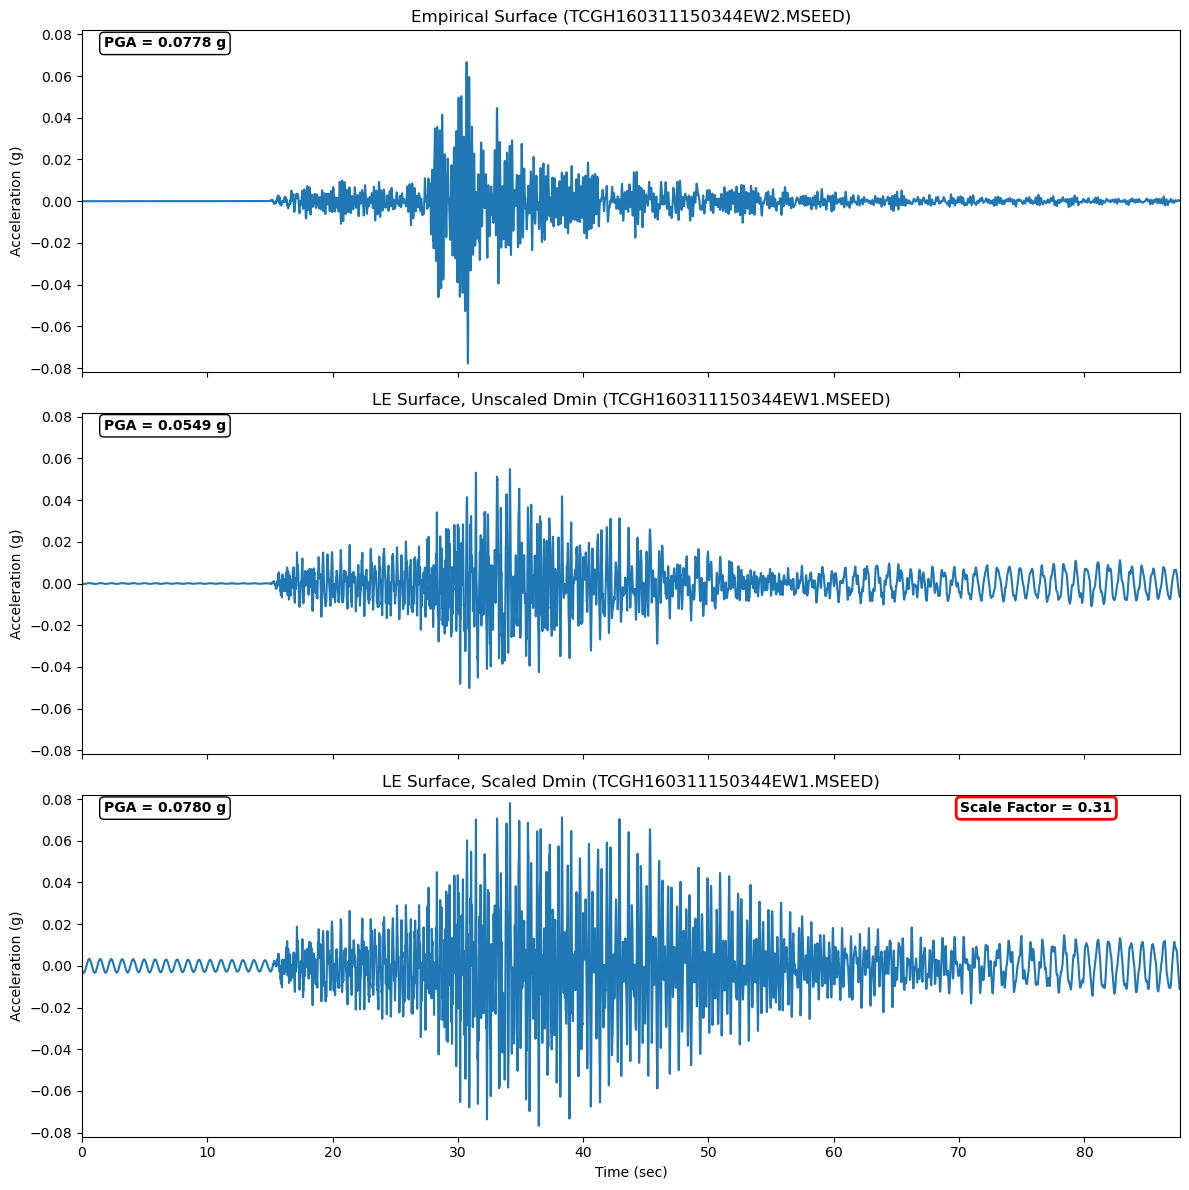

In [22]:
import pystrata
import pandas as pd
import matplotlib.pyplot as plt

uw=20
PI=profile_df['PI'].to_numpy()
OCR=profile_df['OCR'].to_numpy()
mean_stress=profile_df['Mean_Stress'].to_numpy()
thick=profile_df['Thickness'].to_numpy()
vs=profile_df['Vs'].to_numpy()
dmin_df=pd.DataFrame(profile_df['damp_min'])
sf = 1

calc = pystrata.propagation.LinearElasticCalculator()
outputs = pystrata.output.OutputCollection([
    pystrata.output.AccelerationTSOutput(
        pystrata.output.OutputLocation("within", index=0)  # Surface layer (0)
    )
])
outputs_1 = pystrata.output.OutputCollection([
    pystrata.output.AccelerationTSOutput(
        pystrata.output.OutputLocation("within", index=0)  # Surface layer (0)
    )
])

motion_b = site_response_small.convert_to_motion(base_motion,'EW1')[0]
motion_s = site_response_small.convert_to_motion(surface_motion,'EW2')[0]
pga_sf = theo_pga_df['pga_SF'][0]

m_name_s=motion_s.filename
m_name_b=motion_b.filename

# Create figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

accel = motion_s.accels
time_array = motion_s.time_step * np.arange(len(accel))
ax1.plot(time_array, accel)
pga1 = np.max(np.abs(accel))
ax1.text(0.02, 0.95, f'PGA = {pga1:.4f} g', transform=ax1.transAxes,
         bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', linewidth=1),
         fontweight='bold')

ax1.set_title(f"Empirical Surface ({m_name_s})")
ax1.set_ylabel("Acceleration (g)")


unscaled_profile = site_response_small.create_soil_profile(uw, PI, OCR, mean_stress, thick, vs, sf, dmin_df)
calc(motion_b, unscaled_profile, unscaled_profile.location("within", index=-1))
outputs(calc)
accel_output1 = outputs[0]
time_array1 = outputs[0].times
ax2.plot(time_array1, accel_output1.values)
pga2 = np.max(np.abs(accel_output1.values))
ax2.text(0.02, 0.95, f'PGA = {pga2:.4f} g', transform=ax2.transAxes,
         bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', linewidth=1),
         fontweight='bold')
ax2.set_title(f"LE Surface, Unscaled Dmin ({m_name_b})")
ax2.set_ylabel("Acceleration (g)")

scaled_profile = site_response_small.create_soil_profile(uw, PI, OCR, mean_stress, thick, vs, sf, dmin_df*pga_sf)
calc(motion_b, scaled_profile, scaled_profile.location("within", index=-1))
outputs_1(calc)
accel_output2 = outputs_1[0]
time_array2 = outputs_1[0].times
ax3.plot(time_array2, accel_output2.values)
pga3 = np.max(np.abs(accel_output2.values))
ax3.text(0.02, 0.95, f'PGA = {pga3:.4f} g', transform=ax3.transAxes,
         bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', linewidth=1),
         fontweight='bold')
ax3.set_title(f"LE Surface, Scaled Dmin ({m_name_b})")
ax3.set_ylabel("Acceleration (g)")
ax3.set_xlabel("Time (sec)")

max_time = motion_s.time_step * len(accel)
ax1.set_xlim(0, max_time)

y_max = max(
    np.max(np.abs(accel)), 
    np.max(np.abs(accel_output1.values)),
    np.max(np.abs(accel_output2.values)))
y_max = y_max + 0.05 * y_max
ax1.set_ylim(-y_max, y_max)
ax2.set_ylim(-y_max, y_max)
ax3.set_ylim(-y_max, y_max)

scale_text = f'Scale Factor = {pga_sf:.2f}'
box_props = dict(boxstyle='round', facecolor='white', edgecolor='red', linewidth=2)
ax3.text(0.8, 0.95, scale_text, transform=ax3.transAxes, 
         bbox=box_props, fontweight='bold')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()